# Infinite horizon problem


Consider an infinite horizon problem instead. Households make consumption-saving decisions over the infinite horizon, taking interest rates $r_t$ and wage rates $w_t$ given. They supply one unit of labor exogenously and earn labor income $w_t$. The household problem reads as follows:

\begin{align*}
    & \max_{\{c_t,a_{t+1}\}_{t=0}^\infty} \sum_{t=0}^{\infty} \beta^t u(c_t)\\
    \text{s.t.} & \\
    & c_t = (1+r_{t})a_{t} - a_{t+1} + w_t \\
    & a_0\ge 0: \text{given}, a_{t+1} \ge 0~~~\forall t
\end{align*}

## Recursive formulation
Let $V_t(a)$ be the lifetime utility from the viewpoint of time $t$ with asset level $a$, which is defined as:

$$
V_t(a_t) = \max_{a_{t+1}} u((1+r_t)a_t - a_{t+1} + w_t) + \beta V_{t+1}(a_{t+1})
$$

Here, think about the stationary economy in which these prices are constant over time, meaning that we do not need information on time $t$:

$$
V(a) = \max_{a'} u((1+r)a - a' + w) + \beta V(a'),
$$
where $a'$ is the next period's asset position. The solution is the policy function for saving that returns the optimal asset position for next period:

$$
g(a) = \argmax_{a'}  u((1+r)a - a' + w) + \beta V(a')
$$

We want to find solutions for the value function $V(\cdot)$ and the corresponding policy function $g(a)$.

## Solution methods:

### Value Function Iteration (VFI)
1. Guess $V(a)$.
2. Given guessed $V(a)$, compute the implied value function.
3. Compare the implied and guessed value functions and update the guess until convergence.

### Policy Function Iteration (PFI)
1. Guess policy function $g(a)$.
2. Given guessed $g(a)$, compute the implied value function.
3. Given the implied value function, then compute the implied policy function.
4. Compare the implied and guessed policy functions and update the guess until convergence.

In [5]:
### VALUE FUNCTION ITERATION

# parameters
β = 0.98
r = 0.05
y = 1.0

penalty = -1.e+8

# discretization
amin = 1.e-5
amax = 10.0
na   = 1000
agrid = collect(LinRange(amin,amax,na))

# Value function and policy function
Va = zeros(na)
ga = zeros(na)

# convergence criterion
tol = 1.e-7
dif = 1.0
iter = 1
maxiter = 1000

# outer loop: guess and update value function
Va_guessed = copy(Va)
Va_implied = copy(Va)

while (dif>tol)

    # compute optimal saving choices and implied value functions
    ac_start=1
    v_new=0.0
    v0=0.0
    for ac in 1:na
        v0=penalty
        for acc in ac_start:na
            c = (1+r)*agrid[ac]-agrid[acc]+y
            if (c>0)
                v_new=log(c)+β*Va_guessed[acc]
            else
                v_new=penalty
            end

            if (v_new>v0)
                v0=v_new
                ac_start=acc
            else
                break
            end
        end
        Va_implied[ac]=v0
        ga[ac]=agrid[ac_start]
    end

    dif = maximum(abs.(Va_guessed.-Va_implied))

    if (dif<tol)
        Va .= Va_guessed
    else
        # update
        Va_guessed .= (Va_guessed.+Va_implied)./2.0
        iter+=1
    end
    
end

In [6]:
@show dif;
@show iter;

dif = 9.974444736826626e-8
iter = 1490


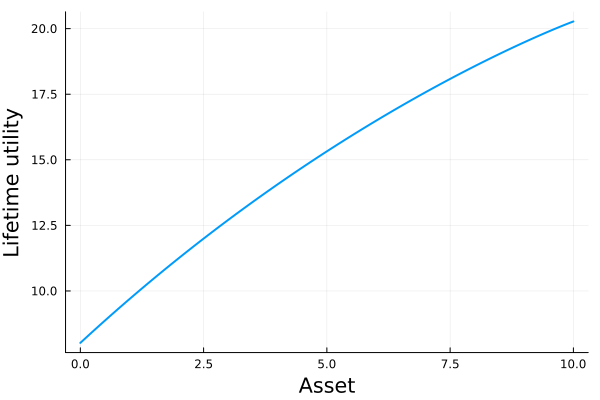

In [7]:
# plot value function and policy function
using Plots
plot(agrid, Va,
    xlabel="Asset",
    ylabel="Lifetime utility",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)

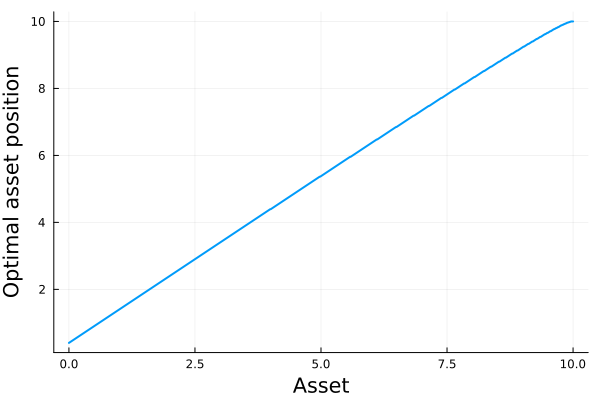

In [8]:
# plot policy function
using Plots
plot(agrid, ga,
    xlabel="Asset",
    ylabel="Optimal asset position",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)

In [10]:
### POLICY FUNCTION ITERATION

# parameters
β = 0.98
r = 0.05
y = 1.0

penalty = -1.e+8

# discretization
amin = 1.e-5
amax = 10.0
na   = 1000
agrid = collect(LinRange(amin,amax,na))

# Value function and policy function
Va = zeros(na) 
ga = zeros(na)

# convergence criterion
tol = 1.e-7
dif = 1.0
iter = 1
maxiter = 1000

# outer loop: guess and update policy function
ga_guessed = copy(ga)
ga_implied = copy(ga)

ga_guessed_arg = ones(Int,na)
ga_implied_arg = ones(Int,na)
# initial guess g(a)=a/2
for ac in 1:na
    ga_guessed_arg[ac] = ac
end

Va_guessed = copy(Va)
Va_implied = copy(Va)

while (dif>tol)

    # compute value function consistent with the guessed policy function
    dif_v = 1.0 # difference of guessed and implied value functions
    iter_v=1
    maxiter_v = 10000
    while (dif_v>tol)
        for ac in 1:na
            # compute value function
            arg_a = ga_guessed_arg[ac]
            c = (1.0+r)*agrid[ac] - agrid[arg_a] + y
            if (c>0)
                Va_implied[ac] = log(c) + β*Va_guessed[arg_a]
            else
                Va_implied[ac] = penalty
            end
            
        end

        dif_v = maximum(abs.(Va_guessed.-Va_implied))
        if (dif_v>tol)
            #update
            Va_guessed .= (Va_guessed.+Va_implied)./2.0
            iter_v+=1
        else
            Va .= Va_guessed
        end

        if (iter_v>maxiter_v)
            println("failure: iter_v>maxiter_v")
        end

    end
    
    # compute implied policy function
    ac_start=1
    v0=0.0
    v_new = 0.0
    # compute optimal saving choices and implied value functions
    dif = 0.0
    for ac in 1:na
        v0=penalty
        for acc in ac_start:na
            c = (1+r)*agrid[ac]-agrid[acc]+y
            if (c>0)
                v_new=log(c)+β*Va[acc]
            else
                v_new=penalty
            end

            if (v_new>v0)
                v0=v_new
                ac_start=acc
            else
                break
            end
        end

        ga_implied_arg[ac] = ac_start
        ga_implied[ac] = agrid[ac_start]
        ac_guess = ga_guessed_arg[ac]

        if (ac_guess ≠ ac_start)
            # update
            dif = abs(ac_guess-ac_start) # if ac_guess==ac_start for any ac, dif=0.
            if (dif==1)
                ga_guessed_arg[ac] = ac_start
            else
                mid_point = (ac_guess+ac_start)/2.0
                ga_guessed_arg[ac] = round(Int, mid_point) 
            end
        end

    end


    if (dif<tol)
        ga .= ga_implied
    else
        iter+=1
    end
    
    if (iter>maxiter)
        println("failure: iter>maxiter")
        break
    end
end
@show dif;
@show iter;

dif = 0.0
iter = 24


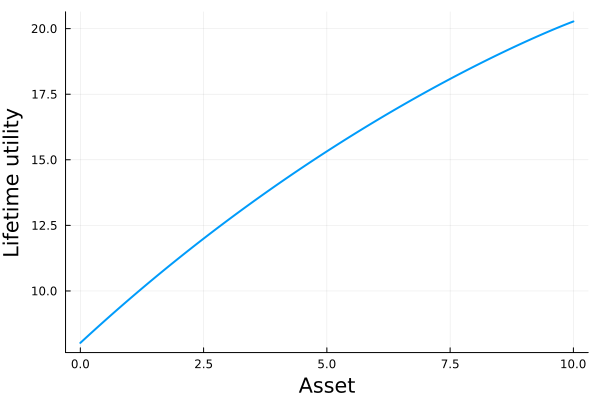

In [11]:
using Plots
plot(agrid, Va,
    xlabel="Asset",
    ylabel="Lifetime utility",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)

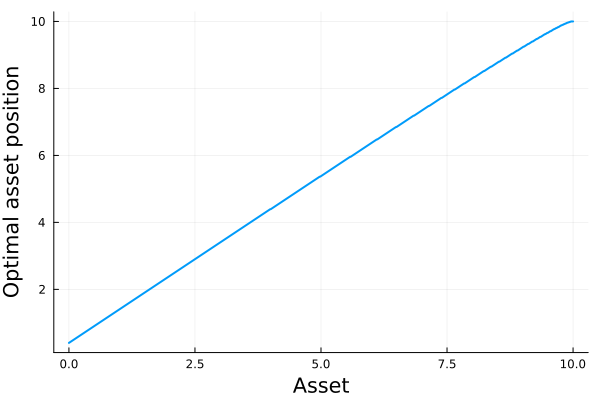

In [12]:
# plot policy function
plot(agrid, ga,
    xlabel="Asset",
    ylabel="Optimal asset position",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14))    # font size for y-axis label)